# Assignment 2 - Scott Wilkinson (V00887986) 

## Q2: Testing KNN Classification with Noise and PCA

A notebook which uses a K-Nearest Neighbours multi-class classifier to predict the written number from MNIST data in a cases of variable noise and varying the number of components included from the principle component analysis (PCA). At the end, I compare the results from this notebook to the last (Q1) and choose the optimal model for this scenario.

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import time

from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## MNIST

The MNIST dataset includes 70,000 images of handwritten digits from 0 to 9. Here, I present examples of those images with a medium amount of noise added to the image. The noise is drawn from a normal distribution and is coadded to the image and re-normalized. In the next cell, I show 30 examples of numbers from 0-9 with a medium amount of added noise to guide and give context to the reader.

(49000,) (21000,)


<Figure size 432x288 with 0 Axes>

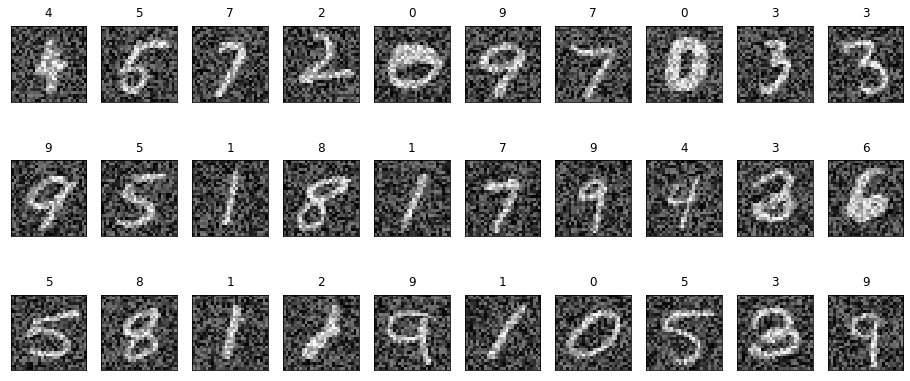

In [3]:
c = 1
# importing and flattening MNIST images
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train= x_train/255.
x_test= x_test/255.
x_train = np.reshape(x_train,(-1,784))
x_test = np.reshape(x_test,(-1,784))

# adding noise
x_train += np.random.rand(60000,784)*c
x_test += np.random.rand(10000,784)*c

# re-normalizing
x_train /= (1+c)
x_test /= (1+c)

inpT = np.concatenate((x_train,x_test))
tarT = np.concatenate((y_train,y_test))

# split into training set (70) and validation set (30)
inp_tr, inp_va, tar_tr, tar_va = train_test_split( inpT, tarT, test_size=0.3, random_state=6)
print (np.shape(tar_tr),np.shape(tar_va))


# presenting some digits

n1=0
n2=30
plt.gray()
fig = plt.figure( figsize=(16,7) )
for k1 in range(n1,n2):
    ax = fig.add_subplot(3,10,k1+1, title=str(int(tar_tr[k1])))
    ax.matshow(inp_tr[k1].reshape((28,28)).astype(float))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

As you can see, the numbers are noisy but still clearly visible to a human reader.

## Principle Component Analysis (PCA)

PCA is a method by which the vectors of greatest variance accross the dataset are ordered as principle components. If data in the data set has $n$ dimensions, then there will be $n$ possible principal components, ordered by the amount of total variance for which each principal component accounts. Thus, taking the first $n$ components of the PCA will give you the $n$ most informative and descriminatory components for your dataset and you can reduce the dimensionality (speed up your code!) without losing much information or performance.  

The example below shows how, given various numbers of components used, a noisy MNIST image can be reconstructed. Note that in the case of 100 components, the number is fairly well reconstructed but much of the noise is not included.

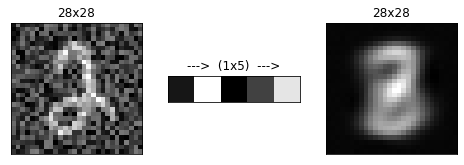

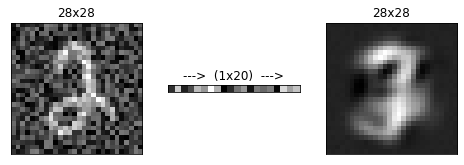

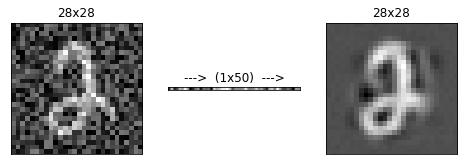

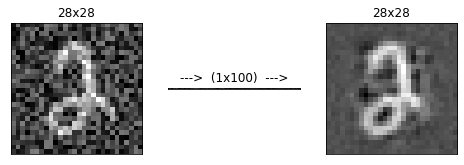

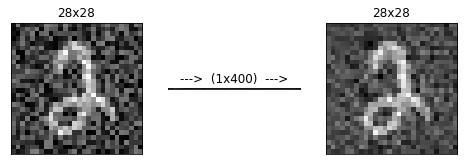

In [4]:
n_pic = np.random.choice(np.arange(len(inp_va)))

for kc in [5,20, 50, 100, 400]:
    n_components=kc
    pca=PCA(n_components=n_components)

    pca.fit(inp_tr)
    inp_tr_pca = pca.transform(inp_tr)
    inp_va_pca = pca.transform(inp_va)

    sx= int(np.sqrt(n_components))
    sy= int(np.sqrt(n_components))
    plt.figure(n_pic, figsize=(8,8))
    approximation = pca.inverse_transform(inp_va_pca[n_pic]) # re-constract the image
    fig = plt.figure(n_pic)
    plt.subplot(1, 3, 1)
    plt.imshow(inp_va[n_pic].reshape(28,28),cmap='gray')
    plt.title('28x28')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 3, 2)
    plt.imshow(inp_va_pca[n_pic].reshape((-1, n_components)),cmap='gray')
    plt.title('--->  (1x'+str(n_components)+')  --->')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 3, 3)
    plt.imshow(approximation.reshape(28,28),cmap='gray')
    plt.title('28x28')
    plt.xticks([])
    plt.yticks([])

    plt.show()

## Finding the optimal p and k for this problem

As we will later see, the model's performance is much worse for the validation set than on the training set. Thus, I created this cell to identify the optimal p and k for this scenario using GridSearchCV. 

I choose a medium amount of noise (seen in above MNIST images) and the middle-of-the-road number of PCA components to include (100). 

Finding an optimal p and k for each iteration of noise and PCA components will take too long, so I will take this medium configuration of all that I test in the next cell (in regards to amount of information retained from PCA and amount of noise added) and assume that, since the data set is the same, the optimal p and k will remain roughly constant (even though I know that is unlikely to be true!).

In [ ]:
# finding optimal p and k using grid search for a medium configuration

# medium noise
c = 1

# importing and flattening MNIST images
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train= x_train/255.
x_test= x_test/255.
x_train = np.reshape(x_train,(-1,784))
x_test = np.reshape(x_test,(-1,784))

# adding noise
x_train += np.random.rand(60000,784)*c
x_test += np.random.rand(10000,784)*c

# re-normalizing
x_train /= (1+c)
x_test /= (1+c)

inpT = np.concatenate((x_train,x_test))
tarT = np.concatenate((y_train,y_test))

# split into training set (70) and validation set (30)
inp_tr, inp_va, tar_tr, tar_va = train_test_split( inpT, tarT, test_size=0.3, random_state=6)
print (np.shape(tar_tr),np.shape(tar_va))

# apply PCA with 100 components (medium amount of information retained)
n_components = 100
pca = PCA(n_components = n_components) 

# apply pca to training data
pca.fit(inp_tr)

# save pca data for training and validation sets
inp_tr = pca.transform(inp_tr)
inp_va = pca.transform(inp_va)

# values to test
K = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,\
    21,22,23,24,25,30,35,40,45,50,55,60,75,100,200]
P = [1,2]
param_grid = [{"n_neighbors": K, "p":P}]
KNN = KNeighborsClassifier()

# testing those parameters
gs = GridSearchCV(KNN, param_grid, cv = 5)
gs.fit(inp_tr, tar_tr)
print(gs.best_params_)

(49000,) (21000,)
{'n_neighbors': 5, 'p': 2}


In this case, it turns out the optimal p and k are the default and so the model is already doing its best and I make no further changes to the test.

## How well can we classify MNIST numbers with various amounts of noise and PCA components?

To answer this question, we will conduct noise tests on three cases:

1. No PCA
2. PCA, taking the first 100 components
3. PCA, taking the first 20

In each case, we will iterate over various amounts of noise and record the accuracy of the classifier.

In [ ]:
# loop through each case we wish to explore
for i in range(3): 
  
  score_train_tr, score_train_va = [],[]
  acc_train_tr, acc_train_va = [],[]

  c_noise = [0, 0.25, 0.5, 1, 1.5, 2, 3, 4.5, 10, 20, 30, 40, 50]

  for c in c_noise:

    # importing and flattening MNIST images
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train= x_train/255.
    x_test= x_test/255.
    x_train = np.reshape(x_train,(-1,784))
    x_test = np.reshape(x_test,(-1,784))

    # adding noise
    x_train += np.random.rand(60000,784)*c
    x_test += np.random.rand(10000,784)*c

    # re-normalizing
    x_train /= (1+c)
    x_test /= (1+c)

    inpT = np.concatenate((x_train,x_test))
    tarT = np.concatenate((y_train,y_test))

    # split into training set (70) and validation set (30)
    inp_tr, inp_va, tar_tr, tar_va = train_test_split( inpT, tarT, test_size=0.3, random_state=6)
    print (np.shape(tar_tr),np.shape(tar_va))

    # this is where we apply PCA (or not) for each case
    if i == 1:

      # if second iteration, apply PCA with 100 components
      n_components = 100
      pca = PCA(n_components = n_components) 

      # apply pca to training data
      pca.fit(inp_tr)

      # save pca data for training and validation sets
      inp_tr = pca.transform(inp_tr)
      inp_va = pca.transform(inp_va)

    elif i == 2:

      # if third iteration, apply PCA with 100 components
      n_components = 20
      pca = PCA(n_components = n_components) 

      # apply pca to training data
      pca.fit(inp_tr)

      # save pca data for training and validation sets
      inp_tr = pca.transform(inp_tr)
      inp_va = pca.transform(inp_va)

    # NOTE: if i == 0 (first iteration), no PCA is applied

    # KNN Classifier
    KNN=KNeighborsClassifier()

    start = time.time()

    # train logistic regression model
    KNN.fit(inp_tr, tar_tr)

    # make predictions for training and validation sets
    pred_tr= KNN.predict(inp_tr)
    pred_va= KNN.predict(inp_va)

    end = time.time()
    time_taken = end - start
    print ('Time regression: ', time_taken)

    print  ('-----------------------------')

    # save accuracy / results for plotting
    score_train_tr_tmp = KNN.score(inp_tr, tar_tr)
    score_train_va_tmp = KNN.score(inp_va, tar_va)

    acc_train_tr_tmp = accuracy_score(tar_tr, pred_tr)
    acc_train_va_tmp = accuracy_score(tar_va, pred_va)

    score_train_tr.append(score_train_tr_tmp)
    score_train_va.append(score_train_va_tmp)

    acc_train_tr.append(acc_train_tr_tmp)
    acc_train_va.append(acc_train_va_tmp)

  # save data to specific list names for plotting
  if i == 0:
    score_train_tr_nopca = score_train_tr.copy()
    score_train_va_nopca = score_train_va.copy()
    acc_train_tr_nopca = acc_train_tr.copy()
    acc_train_va_nopca = acc_train_va.copy()

  if i == 1:
    score_train_tr_pca100 = score_train_tr.copy()
    score_train_va_pca100 = score_train_va.copy()
    acc_train_tr_pca100 = acc_train_tr.copy()
    acc_train_va_pca100 = acc_train_va.copy()

  if i == 2:
    score_train_tr_pca20 = score_train_tr.copy()
    score_train_va_pca20 = score_train_va.copy()
    acc_train_tr_pca20 = acc_train_tr.copy()
    acc_train_va_pca20 = acc_train_va.copy()


11501568/11490434 [==============================] - 0s 0us/step
(49000,) (21000,)
Time regression:  223.74873685836792
-----------------------------
(49000,) (21000,)
Time regression:  215.22302508354187
-----------------------------
(49000,) (21000,)
Time regression:  215.4089639186859
-----------------------------
(49000,) (21000,)
Time regression:  214.64763236045837
-----------------------------
(49000,) (21000,)
Time regression:  213.9666142463684
-----------------------------
(49000,) (21000,)
Time regression:  217.37521052360535
-----------------------------
(49000,) (21000,)
Time regression:  217.74513626098633
-----------------------------
(49000,) (21000,)
Time regression:  217.67439007759094
-----------------------------
(49000,) (21000,)
Time regression:  219.6248230934143
-----------------------------
(49000,) (21000,)
Time regression:  218.18763661384583
-----------------------------
(49000,) (21000,)
Time regression:  218.63723516464233
-----------------------------
(49

The KNN Classifier is slower the logistic regressor in all cases. But the most difficult step is the case where no PCA is applied. In this case, each noise iteration took about 4 minutes to compute! This is because of the dimensionality of the data, each time the algorithm has to average over more data points.

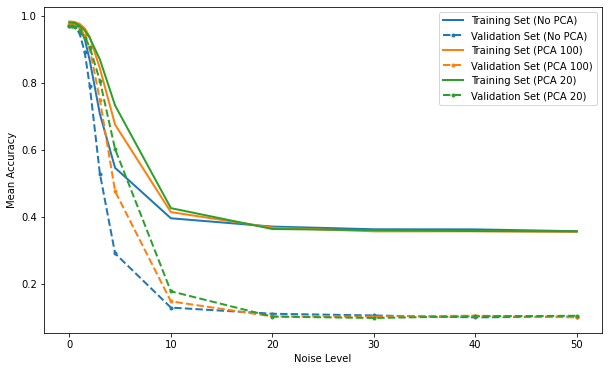

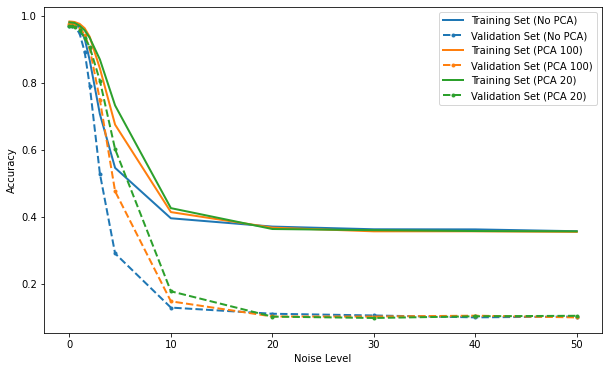

In [ ]:
plt.figure(figsize = (10,6))

plt.plot(c_noise,score_train_tr_nopca, '-', label = 'Training Set (No PCA)', color = 'tab:blue', lw = 2)
plt.plot(c_noise,score_train_va_nopca, '--.', label = 'Validation Set (No PCA)', color = 'tab:blue', lw = 2)

plt.plot(c_noise,score_train_tr_pca100, '-', label = 'Training Set (PCA 100)', color = 'tab:orange', lw = 2)
plt.plot(c_noise,score_train_va_pca100, '--.', label = 'Validation Set (PCA 100)', color = 'tab:orange', lw = 2)

plt.plot(c_noise,score_train_tr_pca20, '-', label = 'Training Set (PCA 20)', color = 'tab:green', lw = 2)
plt.plot(c_noise,score_train_va_pca20, '--.', label = 'Validation Set (PCA 20)', color = 'tab:green', lw = 2)

plt.xlabel('Noise Level')
plt.ylabel('Mean Accuracy')
plt.legend(fancybox = True)
plt.show()

plt.figure(figsize = (10,6))

plt.plot(c_noise,acc_train_tr_nopca, '-', label = 'Training Set (No PCA)', color = 'tab:blue', lw = 2)
plt.plot(c_noise,acc_train_va_nopca, '--.', label = 'Validation Set (No PCA)', color = 'tab:blue', lw = 2)

plt.plot(c_noise,acc_train_tr_pca100, '-', label = 'Training Set (PCA 100)', color = 'tab:orange', lw = 2)
plt.plot(c_noise,acc_train_va_pca100, '--.', label = 'Validation Set (PCA 100)', color = 'tab:orange', lw = 2)

plt.plot(c_noise,acc_train_tr_pca20, '-', label = 'Training Set (PCA 20)', color = 'tab:green', lw = 2)
plt.plot(c_noise,acc_train_va_pca20, '--.', label = 'Validation Set (PCA 20)', color = 'tab:green', lw = 2)

plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.legend(fancybox = True)

plt.show()

Again, the top and bottom plot show identical information but gathered using two different techniques.

In this figure, you can see that as the noise level is increased, the accuracy of the model for both the training and validation sets decreases. Beyond a noise level of about 20, the accuracy remains the same: approximately 40% for all training sets and approximately 10% for all validation sets. When the accuracy reaches 10% the model is as good as random guessing (ie it correctly labels 1 in 10 and there are 10 classes). 

Since the training sets converge to 40%, this model seems to be capable of overfitting itself to the training set in a way that allows it to still perform fairly well, despite high levels of noise. 

What's really interesting is that my results indicate that keeping fewer components from the PCA improves the accuracy of the model (at least in the low to medium noise regimes). I believe this is caused by the PCA focusing only on the components that provide valuable information and somewhat circumventing the problem of additional noise. 

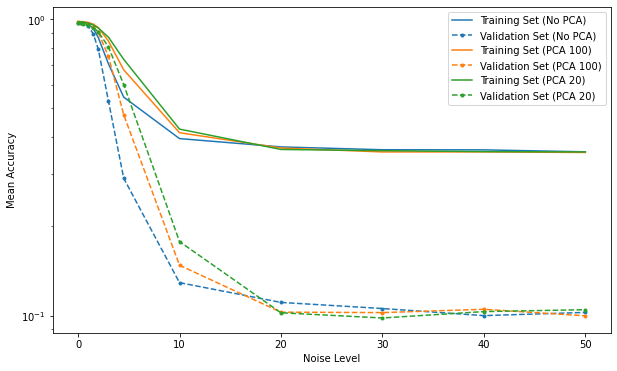

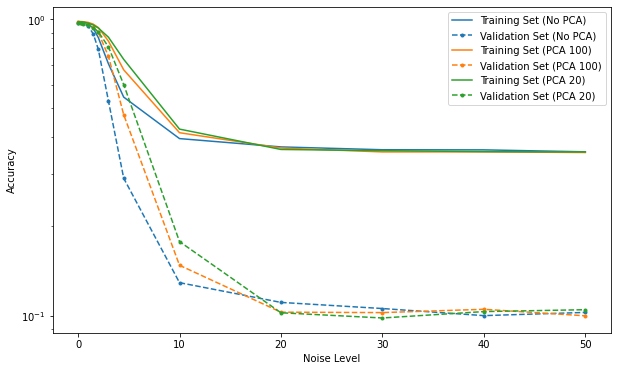

In [ ]:
plt.figure(figsize = (10,6))

plt.semilogy(c_noise,score_train_tr_nopca, '-', label = 'Training Set (No PCA)', color = 'tab:blue')
plt.semilogy(c_noise,score_train_va_nopca, '--.', label = 'Validation Set (No PCA)', color = 'tab:blue')

plt.semilogy(c_noise,score_train_tr_pca100, '-', label = 'Training Set (PCA 100)', color = 'tab:orange')
plt.semilogy(c_noise,score_train_va_pca100, '--.', label = 'Validation Set (PCA 100)', color = 'tab:orange')

plt.semilogy(c_noise,score_train_tr_pca20, '-', label = 'Training Set (PCA 20)', color = 'tab:green')
plt.semilogy(c_noise,score_train_va_pca20, '--.', label = 'Validation Set (PCA 20)', color = 'tab:green')

plt.xlabel('Noise Level')
plt.ylabel('Mean Accuracy')
plt.legend(fancybox = True)

plt.show()

plt.figure(figsize = (10,6))

plt.semilogy(c_noise,acc_train_tr_nopca, '-', label = 'Training Set (No PCA)', color = 'tab:blue')
plt.semilogy(c_noise,acc_train_va_nopca, '--.', label = 'Validation Set (No PCA)', color = 'tab:blue')

plt.semilogy(c_noise,acc_train_tr_pca100, '-', label = 'Training Set (PCA 100)', color = 'tab:orange')
plt.semilogy(c_noise,acc_train_va_pca100, '--.', label = 'Validation Set (PCA 100)', color = 'tab:orange')

plt.semilogy(c_noise,acc_train_tr_pca20, '-', label = 'Training Set (PCA 20)', color = 'tab:green')
plt.semilogy(c_noise,acc_train_va_pca20, '--.', label = 'Validation Set (PCA 20)', color = 'tab:green')

plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.legend(fancybox = True)

plt.show()

Same information but with a log scale y-axis, if you're interested.

## So should we use Logistic Regressor or KNN for this task?

At high levels of noise, the logistic regressor performs worse than the KNN for the training set, but much better on validation set. However, the validation set is what really matters as it is data that the model hasn't seen in training and better indicated the ability of the model to generalize.

The training and validation set performance is also much more similar in the case of the logistic regressor, which indicates it is less susceptible to overfitting to the data.

Finally, the logistic regressor is also faster, which is more convenient when working on bigger datasets of datasets with high dimensionality.

Now, I conduct a test case on each model (logistic regressor in the last notebook) where I specifically compare the performance of each model on relatively high noise. To give the KNN an advantage, I take the first 20 components from the PCA for the KNN and the first 100 for the logistic regressor.

In [17]:
# running the model

# medium noise
c = 10

# importing and flattening MNIST images
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train= x_train/255.
x_test= x_test/255.
x_train = np.reshape(x_train,(-1,784))
x_test = np.reshape(x_test,(-1,784))

# adding noise
x_train += np.random.rand(60000,784)*c
x_test += np.random.rand(10000,784)*c

# re-normalizing
x_train /= (1+c)
x_test /= (1+c)

inpT = np.concatenate((x_train,x_test))
tarT = np.concatenate((y_train,y_test))

# split into training set (70) and validation set (30)
inp_tr, inp_va, tar_tr, tar_va = train_test_split( inpT, tarT, test_size=0.3, random_state=6)
print (np.shape(tar_tr),np.shape(tar_va))

# apply PCA with 100 components (medium amount of information retained)
n_components = 20
pca = PCA(n_components = n_components) 

# apply pca to training data
pca.fit(inp_tr)

# save pca data for training and validation sets
inp_tr = pca.transform(inp_tr)
inp_va = pca.transform(inp_va)

# KNN Classifier
KNN=KNeighborsClassifier()

start = time.time()

# train logistic regression model
KNN.fit(inp_tr, tar_tr)

# make predictions for training and validation sets
pred_tr= KNN.predict(inp_tr)
pred_va= KNN.predict(inp_va)

end = time.time()
time_taken = end - start
print ('Time regression: ', time_taken)

(49000,) (21000,)
Time regression:  64.649897813797


In [18]:
print ("Recall (TR) = ", np.mean(metrics.recall_score(tar_tr, pred_tr, average = None)))
print ("Recall (VA) = ", np.mean(metrics.recall_score(tar_va, pred_va, average = None)))

print ("Accuracy (TR) = ", metrics.accuracy_score(tar_tr, pred_tr))
print ("Accuracy (VA) = ", metrics.accuracy_score(tar_va, pred_va))

print ("Precision (TR) = ", np.mean(metrics.precision_score(tar_tr, pred_tr, average = None)))
print ("Precision (VA) = ", np.mean(metrics.precision_score(tar_va, pred_va, average = None)))

Recall (TR) =  0.4301052707495189
Recall (VA) =  0.18416419155204364
Accuracy (TR) =  0.4352244897959184
Accuracy (VA) =  0.1859047619047619
Precision (TR) =  0.44623723294351275
Precision (VA) =  0.17390218919292752


In [2]:
0.3071904761904762/0.1859047619047619

1.6524077868852458

Comparing the two models performances, the KNN has worse metrics for the validation set (which matters more than the training set) for all three of recall, accuracy and precision.

In the case of accuracy, the logistic regression performs 1.65 times better at this level of noise.

In [21]:
#https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
 

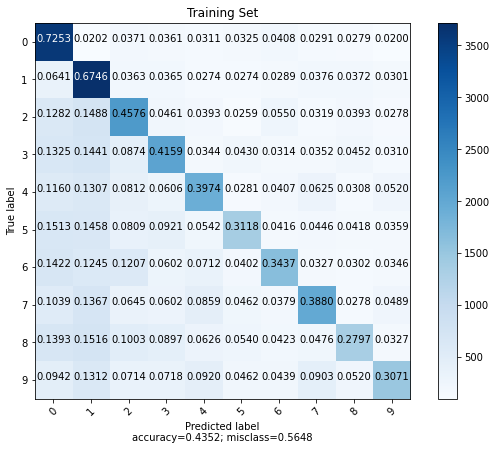

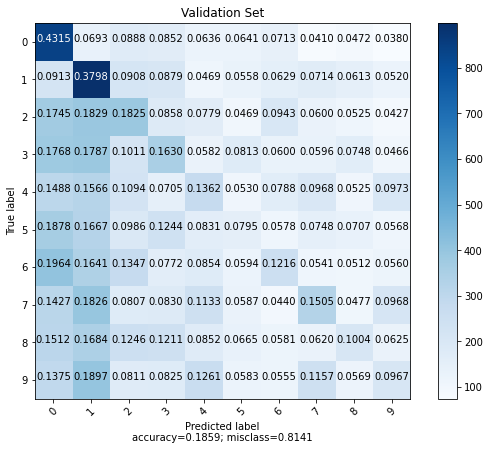

In [23]:
cf_matrix = metrics.confusion_matrix(tar_tr,pred_tr)
plot_confusion_matrix(cf_matrix, target_names = ['0','1','2','3','4','5','6','7','8','9'], title = 'Training Set')

cf_matrix = metrics.confusion_matrix(tar_va,pred_va)
plot_confusion_matrix(cf_matrix, target_names = ['0','1','2','3','4','5','6','7','8','9'], title = 'Validation Set')


Comparing the confusion matrices shows that the KNN model performs fairly poorly (barely better than guessing) for all numbers except for 0 and 1 (which have simple and distinct features). 

Meanwhile, the confusion matrix for the logistic regression classifier more consistent performance across the classes (except for 5 with shares many feaures with other numbers and 1 and 0 for reasons above). This is yet another reason to choose the logistic regression classifier.

(49000,) (21000,)


<Figure size 432x288 with 0 Axes>

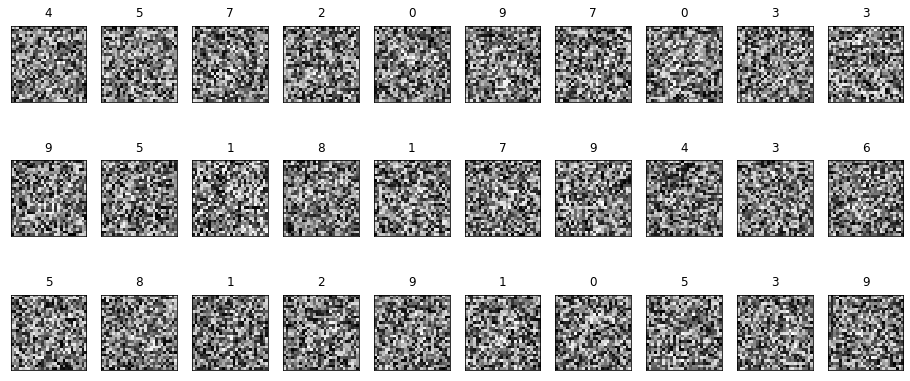

In [25]:
c = 10
# importing and flattening MNIST images
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train= x_train/255.
x_test= x_test/255.
x_train = np.reshape(x_train,(-1,784))
x_test = np.reshape(x_test,(-1,784))

# adding noise
x_train += np.random.rand(60000,784)*c
x_test += np.random.rand(10000,784)*c

# re-normalizing
x_train /= (1+c)
x_test /= (1+c)

inpT = np.concatenate((x_train,x_test))
tarT = np.concatenate((y_train,y_test))

# split into training set (70) and validation set (30)
inp_tr, inp_va, tar_tr, tar_va = train_test_split( inpT, tarT, test_size=0.3, random_state=6)
print (np.shape(tar_tr),np.shape(tar_va))


# presenting some digits

n1=0
n2=30
plt.gray()
fig = plt.figure( figsize=(16,7) )
for k1 in range(n1,n2):
    ax = fig.add_subplot(3,10,k1+1, title=str(int(tar_tr[k1])))
    ax.matshow(inp_tr[k1].reshape((28,28)).astype(float))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

Finally, for context, I include what the noisy images for this test actually look like. I think it's amazing that the logistic regression classifier can use this to achieve an accuracy of 31% on the validation set. Very cool.

## Conclusions

1. In contrast to the logistic regression classifier from Q1, the KNN classifier had improved accuracy when fewer components from the PCA were included in training.

2. The KNN was shown to 
    
    a. overfit to the training set and perform very poorly on the validation set;
    
    b. train more slowly than the logistic regression classifier;
    
    c. perform worse on the validation sets than the logistic regression classifier;
    
    d. perform inconsistently across the various classes, in many cases having equal performance as random guessing.
    
For these reasons (and more from the discussion above), the logistic regression classifier is deemed to be better suited for this scenario.